# Can we group clinical measurements by the underlying physiology/clinical information they intend to inform about?

In [1]:
import numpy as np
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
# Custom import
sys.path.append('../src/')
from Thomas_code import patients, feature_conversion
import flm_tools

# The workhorse of this notebook
import lohpo

The analysis done on masterthesis01 led me to consider alternative ways to deal with clinical measurements. In particular, how could I understand systematically which clinical information is uniquely determined by a measurement, and what is redundant?  
Consider the example of glucose tests. I observed 11 clinical tests for glucose concentration in the following settings: in blood, in blood by automated test strip, in body fluid, in capillary blood, in capillary blood by glucometer, in cerebrospinal fluid, in serum or plasma, in urine, in urine by automated test strip, in urine by test strip, and in venous blood. Some of these are legitimately similar (those on test strips and automated test strip), but others would be different: While plasma glucose concentration can be used to assess hyperglycemia, a glucose in body fluid concentration test may indicate an infection or even a malignant tumor in the area where said body fluid was collected. Glucose concentration is far from the only example of an assay that is non-trivial to interpret but still has a degree of clinical redundancy.  

So what can we do? How about we use measurements to define phenotypes (for example, if glucose is beyond a certain value, the patient has hyperglycemia)? If we can do this systematically, it would increase interpretability of the data and reduce its redundancy.  
  
  This notebook documents the exploration of the Human Phenotype Ontology (HPO) for this purpose. It employs a custom-made Python package (lohpo) that leverages previous work by Zhang et. al. (https://hpo.jax.org/app/tools/loinc2hpo) in mapping tests (uniquely identified with LOINC codes) onto HPO terms (uniquely identified by HP codes) through the curation of a mapping file.

### Get the main data table

In [4]:
clean_all_table = flm_tools.get_cleaned_data(multiple_visits='all',
                                            version='2021-06-02/210602_digest_including_basic_endpoints_and_sofa')
clean_all_table = flm_tools.add_column_with_day_of_stay(clean_all_table)

# In case some measurements are NOT encoded in LOINC, restrict measurements to those encoded in LOINC
a = clean_all_table['measurement_vocabulary_id'] == 'LOINC'
clean_all_table = clean_all_table.loc[a]

### The following lines of code load all that's needed to merge HPO data with ours

In [5]:
# Loading a dictionary containing the mapped LOINC to HPO codes
value = lohpo.AnnotationLoader.load()

# Loading a dictionary containing the HPO terms associated with the HPO codes
header, result = lohpo.HpoTermListLoader.load()

In [6]:
# This is the code block that converts measurements in dataset into HPO annotations

codes = set(clean_all_table["measurement_concept_code"])

frames = []

for code in codes:
    f = clean_all_table['measurement_concept_code'] == code
    df = clean_all_table.loc[f].copy()
    loincId = lohpo.LoincId.from_code(code)
    loinc2hpo = value.get(loincId, None)
    
    if loinc2hpo is not None:
        for hpo_term in loinc2hpo.candidateHpoTerms.values():
            if hpo_term.isNegated:
                df.loc[:, 'HPO_code'] = hpo_term.id
                hpo_annot = result.get(hpo_term.id)
                df.loc[:, 'HPO_annotation'] = hpo_annot.name
                
        frames.append(df)
    else:
        df.loc[:, 'HPO_code'] = None
        df.loc[:, 'HPO_annotation'] = None
        frames.append(df)
clean_all_table = pd.concat(frames)

In [7]:
# Defining a pandas table (complete_HPO) containing only successfully mapped entries
b = clean_all_table['HPO_annotation'].notnull()
complete_HPO = clean_all_table.loc[b]

### Question 1: How many entries in our dataset are we able to map?

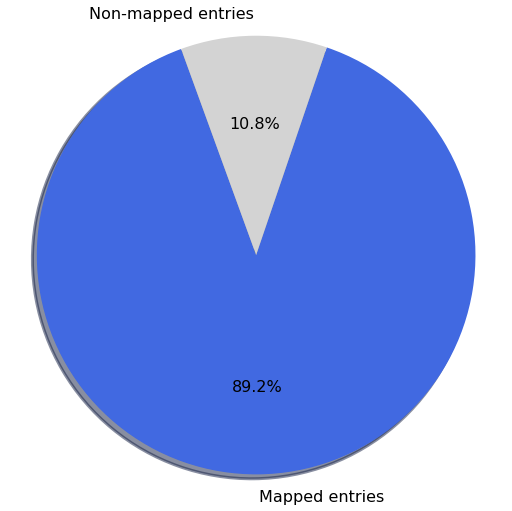

In [8]:
mapped_entries = len(complete_HPO)
all_entries = len(clean_all_table)
non_mapped_entries = all_entries - mapped_entries
y = np.array([mapped_entries, non_mapped_entries])

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7), constrained_layout=True)

ax.pie(y,
       labels=['Mapped entries','Non-mapped entries'],
       autopct = '%1.1f%%',
       shadow = True,
       colors=['royalblue','lightgrey'],
       wedgeprops = {'linewidth': 3},
       textprops={'fontsize': 16},
       startangle=110)
ax.axis('equal')
plt.show()

Awesome! We can map almost all of our dataset.  
BUT  
It is very likely that this is simply a reflection of the fact that a handful of measurements are frequently given (vitals, labs, etc.).  
The real question is:

### Question 2: What's the mapping coverage for our count of distinct clinical measurements?

In [9]:
print(f"Out of a total of {len(clean_all_table['measurement_concept_name'].drop_duplicates())} distinct measurements,")
measurements = list(complete_HPO['measurement_concept_name'].drop_duplicates())
phenotypes = list(complete_HPO['HPO_annotation'].drop_duplicates())
mapped_hpo_codes = list(complete_HPO['HPO_code'].drop_duplicates())
print(f"{len(measurements)} of them ({(len(measurements)/len(clean_all_table['measurement_concept_name'].drop_duplicates()))*100:.2f}%) are mapping onto {len(phenotypes)} distinct HPO annotations")

Out of a total of 570 distinct measurements,
205 of them (35.96%) are mapping onto 135 distinct HPO annotations


Hmmmm, well, not even half of them. At some level, this is not too bad if we want to deal with daily statuses and build a model of patient daily states in the ICU (since we are likely mapping frequently-given tests). But as I mention in mastersthesis01, we'd like to have as full a view as possible (later on I'll show a neat feature of the HPO that can help fill in the blanks).  
  
  Nevertheless, the main objective in using the HPO is assessing if it can reduce dimensions. That's what I explore next.

### Question 3: On average, how many measurements map onto a given HPO term?

In [10]:
measurements_per_phenotype = []

for hpo_annotation in phenotypes:
    f = clean_all_table['HPO_annotation'] == hpo_annotation
    df = clean_all_table.loc[f]
    measurements_per_phenotype.append(len(df['measurement_concept_name'].drop_duplicates()))

In [11]:
measurements_per_phenotype = pd.Series(measurements_per_phenotype)
c = measurements_per_phenotype.value_counts()
conteo = c.values
resultado = c.index
df = pd.DataFrame({"test_per_hpo": resultado, "counts": conteo})

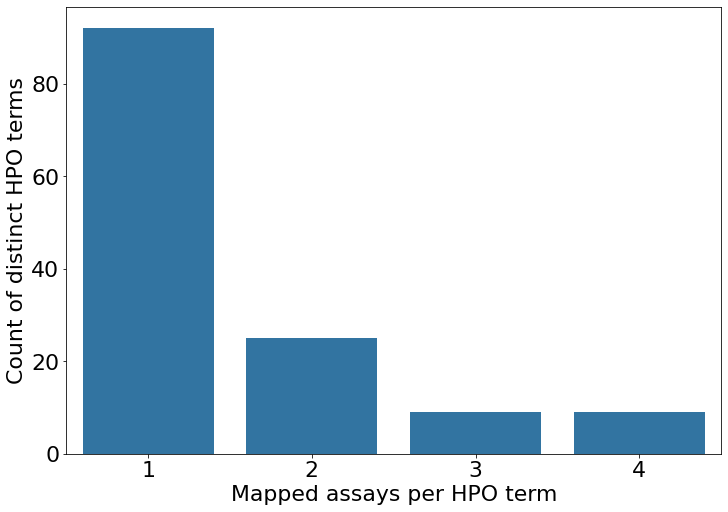

In [12]:
fig1, ax1 = plt.subplots(1,1,figsize=(10,7), constrained_layout=True)
plot = sns.barplot(x="test_per_hpo",
                  y="counts",
                  data=df,
                   color='tab:blue',
                   ax=ax1)

ax1.set_ylabel('Count of distinct HPO terms', size=22)
ax1.set_xlabel('Mapped assays per HPO term', size=22)
ax1.tick_params(axis='x', labelsize=22)
ax1.tick_params(axis='y', labelsize=22)
plt.show()

Nice! It does group a good chunk of the tests. As expected, around 90 HPO terms capture just one clinical measurement/test, but the rest of them group two or more. That's good enough.

### Looking at glucose

In [13]:
g = ['Glucose' in measurement for measurement in list(clean_all_table['measurement_concept_name'])]
glucose_table = clean_all_table.loc[g, ['measurement_concept_name', 'HPO_annotation']]
glucose_table.drop_duplicates()

,measurement_concept_name,HPO_annotation
2330851,Glucose [Mass/volume] in Urine by Automated te...,None
320557,Glucose [Mass/volume] in Body fluid,None
2358646,Glucose [Mass/volume] in Venous blood,None
2383690,Glucose [Mass/volume] in Urine,Abnormality of urine glucose concentration
2333917,Glucose [Mass/volume] in Urine by Test strip,Abnormality of urine glucose concentration
2384859,Glucose [Mass/volume] in Capillary blood by Gl...,Abnormal blood glucose concentration
510583,Glucose [Mass/volume] in Cerebral spinal fluid,Abnormal CSF glucose level
2332358,Glucose [Mass/volume] in Blood by Automated te...,Abnormal blood glucose concentration
2381447,Glucose [Mass/volume] in Blood,Abnormal blood glucose concentration
2336365,Glucose [Mass/volume] in Serum or Plasma,Abnormal blood glucose concentration


Curiously, the annotation file did not contain a mapping for glucose in body fluid. A bit of research reveals that such mapping would be impossible to know, because the body fluid is not specified in the LOINC name. Unavoidable information loss.  
The above table was the genesis of this figure:  
<img src = '../src/measurements to HPO.png'></img>

## Conclusions  
Using the HPO is promising. We just need to:  
-Increase the number of LOINC-identified tests that map to the HPO. We contacted people at The Jackson Laboratory who have developed methods to perform this mapping to collaborate.  
-Use reference ranges already present in Northwestern Memorial Hospital's lab to further leverage the HPO. This is because, if we can use the result of a test, we could map to more specific terms, such as fever, eleveated C-reactive protein concentration, hyperglycemia, uremia, etc. Having that would allow us to interpret test results and build physiologic state vectors for each patient. As of December 2021, the Enterprise Data Warehouse team, in charge of ETL processes within NMH, has delivered a dataset on reference ranges used to interpret numerical tests in our data!

## P.S. Another nice feature of the HPO

As a biomedical ontology, the HPO is hierarchical in structure.
<img src = '../src/hpo-diagram.png'></img>
Image credit: https://hpo.jax.org/app/tools/loinc2hpo

We at the lab envision using this feature to fine-tine the granularity level of the variables we'll use to model clinical progression in the ICU: Since our patients are enrolled on the basis of pneumonia, it would make sense to be granular with variables related to sepsis (creatinine, blood cell counts, etc) and infectious disease (bacterial load, etc.) but coarse with other ailments (cancer, diabetes, etc.). This potential level of control in the granularity of our features can help in building a predictive model that can ultimately inform on the biology behind outcomes.

Now, one funny issue is that I could not find nice visualizations of the HPO hierarchy anywhere. So the following lines document my initial attempt to see it. I envision being able to produce an interactive tree so that clinicians and researchers can explore the above idea further.

In [14]:
import networkx as nx

In [15]:
file_path =  r'../src/lohpo/resources/hp_latest.obo'
with open(file_path, 'r', encoding = 'utf-8') as file_in:
    data = file_in.readlines()

### Build data structure

In [16]:
nodes = []
counter = 0
number_of_parents = []
while counter < len(data):
    if data[counter] != '[Term]\n':
        counter += 1
        continue
    counter += 1
    if counter == len(data) - 1:
        break

    nodes.append({})
    n = 1
    while data[counter] != '[Term]\n':
#         print(counter, data[counter])
        aux = data[counter].split(':')
        if len(aux) > 1:
            if aux[0].strip() == 'is_a':
                nodes[-1][aux[0].strip()+str(n)] = ":".join(aux[1:]).strip()
                n += 1
            else:
                nodes[-1][aux[0].strip()] = ":".join(aux[1:]).strip()

        counter += 1
        number_of_parents.append(n)
        if counter == len(data) - 1:
            break

print(f"There are {len(nodes)} nodes in file.\n\nThe last one is:\n{nodes[-1]}")

There are 16544 nodes in file.

The last one is:
{'id': 'HP:5000048', 'name': 'Anti-Kv1.4 antibody', 'def': '"The presence of autoantibodies (immunoglobulins) in the blood circulation that react against the voltage-gated potassium channel Kv1.4." [PMID:22167224, PMID:30918333]', 'is_a1': 'HP:0030057 ! Autoimmune antibody positivity', 'created_by': 'ORCID:0000-0002-3387-1836'}


### Clean parent node info

In [17]:
k = 0
for node in nodes:
    
#     print(k, node.keys())

    if 'is_a1' in node.keys():
        aux = node['is_a1'].split('!')
        node['parent_ids'] = [aux[0].strip()]
        node['parent_names'] = [aux[1].strip()]
        
    if 'is_a2' in node.keys():
        aux = node['is_a2'].split('!')
        node['parent_ids'].append(aux[0].strip())
        node['parent_names'].append(aux[1].strip())
    
    if 'is_a3' in node.keys():
        aux = node['is_a3'].split('!')
        node['parent_ids'].append(aux[0].strip())
        node['parent_names'].append(aux[1].strip())
#         print(node)

    if 'is_a4' in node.keys():
        aux = node['is_a4'].split('!')
        node['parent_ids'].append(aux[0].strip())
        node['parent_names'].append(aux[1].strip())
        
    if 'is_a5' in node.keys():
        aux = node['is_a5'].split('!')
        node['parent_ids'].append(aux[0].strip())
        node['parent_names'].append(aux[1].strip())
        
    k += 1

### Save data as list of arcs for creating DiGraph using networkx

Children point to parent. See https://networkx.org/documentation/stable/reference/classes/digraph.html for details.
Switching to parent pointing to children for layout purposes

In [18]:
all_arcs_ids = []
all_arcs_names = []

node_ids = []
node_names = []
# first_level_nodes = ['All']
# first_level_edges = []

for node in nodes:
    node_names.append(node['name'])
    node_ids.append(node['id'])
    
    if 'parent_ids' in node.keys():
        for i in range(len(node['parent_ids'])):
            all_arcs_ids.append( (node['parent_ids'][i], node['id']) )
            all_arcs_names.append( (node['parent_names'][i], node['name']) )

print(f"There are {len(all_arcs_names)} edges in directed graph.\n\nThe first three are:\n{all_arcs_names[:3]}")
print(f"There are {len(node_names)} nodes in directed graph\n")

print(f"There are {len(all_arcs_ids)} edges in directed graph.\n\nThe first three are:\n{all_arcs_ids[:3]}")
print(f"There are {len(node_ids)} nodes in directed graph")

There are 20464 edges in directed graph.

The first three are:
[('Growth abnormality', 'Abnormality of body height'), ('Renal cyst', 'Multicystic kidney dysplasia'), ('All', 'Mode of inheritance')]
There are 16544 nodes in directed graph

There are 20464 edges in directed graph.

The first three are:
[('HP:0001507', 'HP:0000002'), ('HP:0000107', 'HP:0000003'), ('HP:0000001', 'HP:0000005')]
There are 16544 nodes in directed graph


These are a lot of terms and edges. The graph will likely be a mess. Let's just focus on the subtree that we can generate using terms mapped by our data.

### Let's see if the subgraph that includes terms that are being mapped by dataset is more manageable to draw

In [19]:
import json

with open('../files/relevant_hpo_names.json', 'r') as infile:
    mapped_hpo_names = json.load(infile)

In [20]:
# This takes care of an HPO name that is obsolete in the LOINC2HPO library
mapped_hpo_names = ['Elevated total serum tryptase' if x=='obsolete Abnormal serum tryptase concentration' else x for x in mapped_hpo_names]

# Also, there are cases where the name in the library is a synonym.
# There must be a better way to deal with synonyms, but will content myself for now with doing the following.
# Well, the problem disappears as soon as I use HPO codes rather than names.
mapped_hpo_names = ['Decreased circulating dehydroepiandrosterone-sulfate concentration' if x=='Decreased circulating dehydroepiandrosterone-sulfate level' else x for x in mapped_hpo_names]

mapped_hpo_names = ['Increased circulating troponin I concentration' if x=='Increased troponin I level in blood' else x for x in mapped_hpo_names]

mapped_hpo_names = ['Increased circulating troponin T concentration' if x=='Increased troponin T level in blood' else x for x in mapped_hpo_names]

mapped_hpo_names = ['Elevated circulating alanine aminotransferase concentration' if x=='Elevated serum alanine aminotransferase' else x for x in mapped_hpo_names]

mapped_hpo_names = ['Abnormal circulating luteinizing hormone concentration' if x=='Abnormal circulating luteinizing hormone level' else x for x in mapped_hpo_names]

mapped_hpo_names = ['Abnormal circulating antimullerian hormone concentration' if x=='Abnormal antimullerian hormone level' else x for x in mapped_hpo_names]

mapped_hpo_names = ['Elevated circulating C-reactive protein concentration' if x=='Elevated C-reactive protein level' else x for x in mapped_hpo_names]

mapped_hpo_names = ['Abnormal circulating testosterone concentration' if x=='Abnormal serum testosterone level' else x for x in mapped_hpo_names]

mapped_hpo_names = ['Increased circulating procalcitonin concentration' if x=='Increased circulating procalcitonin level' else x for x in mapped_hpo_names]

mapped_hpo_names = ['Elevated circulating aspartate aminotransferase concentration' if x=='Elevated serum aspartate aminotransferase' else x for x in mapped_hpo_names]

mapped_hpo_names = ['Abnormal circulating follicle-stimulating hormone concentration' if x=='Abnormal circulating follicle-stimulating hormone level' else x for x in mapped_hpo_names]

### Generating the graph object

In [21]:
G = nx.DiGraph()
G.add_nodes_from(node_names)
G.add_edges_from(all_arcs_names)

In [22]:
nodes_for_subgraph = []

for low_level_node in mapped_hpo_names:
    
    # In this line, I'm getting all parent and child terms of those mapped by our data
    if low_level_node in node_names:
        nodes_for_subgraph.append(low_level_node)
        nodes_for_subgraph.extend(nx.descendants(G, low_level_node))
        nodes_for_subgraph.extend(nx.ancestors(G, low_level_node))        
            
    else:
        print(f"Something is wrong with the parsing of the HPO file. This term isn't present: {low_level_node}")
        continue
        
nodes_for_subgraph = list(set(nodes_for_subgraph))

# Removing a useless parent term
nodes_for_subgraph.remove('All')

In [23]:
# Getting the differential coloring of mapped HPO terms vs. the rest
for_coloring = {}
for_sizing = {}

for nombre in nodes_for_subgraph:
    if nombre in mapped_hpo_names:
        for_coloring[nombre] = '#377eb8'
        for_sizing[nombre] = 12
    else:
        for_coloring[nombre] = '#999999'
        for_sizing[nombre] = 8

values = [for_coloring.get(node, 0.25) for node in G.subgraph(nodes_for_subgraph).nodes()]

## The tree!

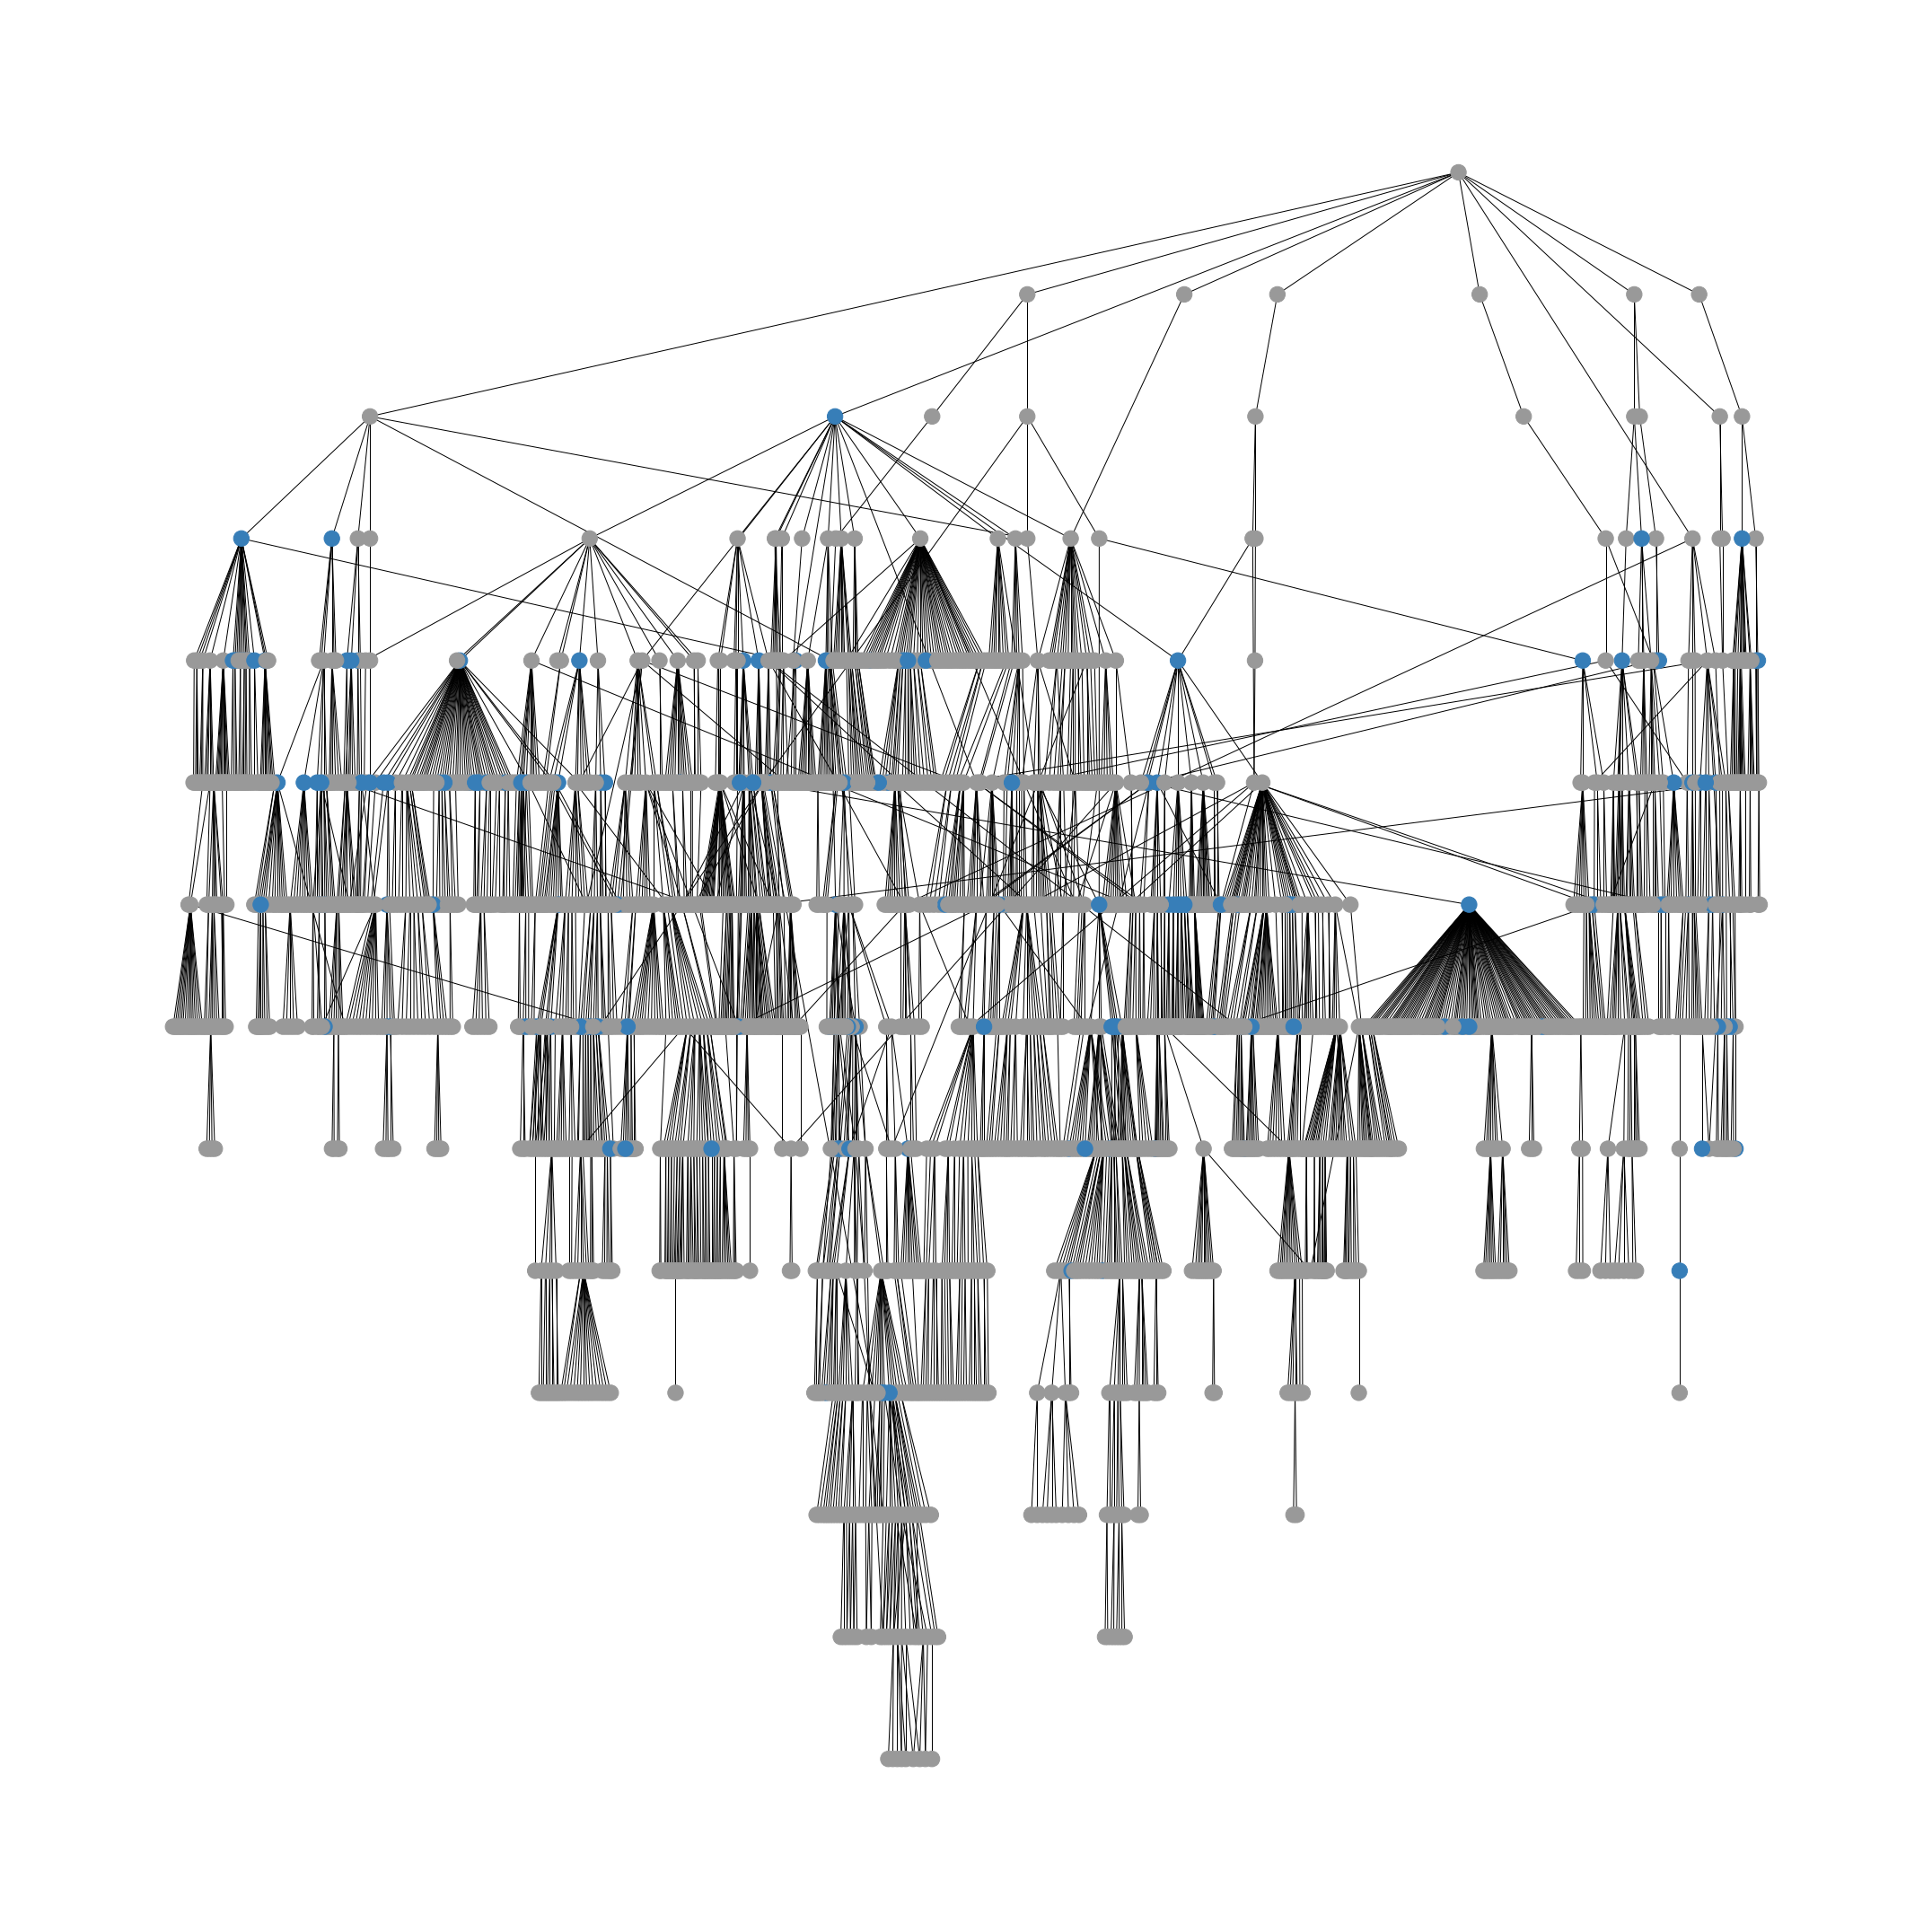

In [24]:
with open('../files/layout5.json', 'r') as infile:
    layout = json.load(infile)
    
mapped_hpo_tree = G.subgraph(nodes_for_subgraph).copy()

fig2, ax2 = plt.subplots(1,1, figsize=(30,30))
nx.draw(mapped_hpo_tree, cmap=plt.get_cmap('Accent'), node_color=values,
        pos=layout, ax=ax2, arrows=False, with_labels=False)

plt.tight_layout()
plt.show()

Boy that's a lot! I'm representing in blue the terms directly mapped by a clinical measurement in the pneumonia data. I can see that not every term is low in the hierarchy; sometimes measurements map to high-level terms directly.

To add interactivity to the plots, I explored Bokeh to create trees in which I could hover my mouse on nodes, and see what terms they represented.

### Interactive graph visualization with Bokeh

In [25]:
from bokeh.io import output_notebook, show, save, output_file
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, LinearColorMapper
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool)
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Spectral4

This is to get the nodes and edges of specific subgraphs

In [26]:
genitourinary = ['Abnormality of the genitourinary system'] + list(nx.descendants(mapped_hpo_tree, 'Abnormality of the genitourinary system'))
nervous = ['Abnormality of the nervous system'] + list(nx.descendants(mapped_hpo_tree, 'Abnormality of the nervous system'))
endocrine = ['Abnormality of the endocrine system'] + list(nx.descendants(mapped_hpo_tree, 'Abnormality of the endocrine system'))
cardiovascular = ['Abnormality of the cardiovascular system'] + list(nx.descendants(mapped_hpo_tree, 'Abnormality of the cardiovascular system'))
blood = ['Abnormality of blood and blood-forming tissues'] + list(nx.descendants(mapped_hpo_tree, 'Abnormality of blood and blood-forming tissues'))
homeostasis = ['Abnormality of metabolism/homeostasis'] + list(nx.descendants(mapped_hpo_tree, 'Abnormality of metabolism/homeostasis'))
respiratory = ['Abnormality of the respiratory system'] + list(nx.descendants(mapped_hpo_tree, 'Abnormality of the respiratory system'))
immune = ['Abnormality of the immune system'] + list(nx.descendants(mapped_hpo_tree, 'Abnormality of the immune system'))
digestive = ['Abnormality of the digestive system'] + list(nx.descendants(mapped_hpo_tree, 'Abnormality of the digestive system'))
cellular = ['Abnormal cellular phenotype'] + list(nx.descendants(mapped_hpo_tree, 'Abnormal cellular phenotype'))

In [27]:
for_coloring = {}
for_sizing = {}

for nombre in mapped_hpo_tree.subgraph(immune).nodes():
    if nombre in mapped_hpo_names:
        for_coloring[nombre] = '#377eb8'
        for_sizing[nombre] = 12
    else:
        for_coloring[nombre] = '#999999'
        for_sizing[nombre] = 8

values = [for_coloring.get(node, 0.25) for node in mapped_hpo_tree.subgraph(immune).nodes()]

Let's plot the immune system subgraph

In [28]:
nx.set_node_attributes(mapped_hpo_tree.subgraph(immune), for_coloring, 'mapped_nodes')
nx.set_node_attributes(mapped_hpo_tree.subgraph(immune), for_sizing, 'node_size')

In [29]:
with open('../files/layout_immune.json', 'r') as infile:
    layout = json.load(infile)

In [30]:
#Choose a title!
title = 'Immune'

# For in-notebook display of tree
output_notebook()

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Term", "@index")]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset",
              active_scroll='wheel_zoom',
              width=2500,
              height=2500,
              title=title)

#Create a network graph object with spring layout
network_graph = from_networkx(mapped_hpo_tree.subgraph(immune),
                              layout,
                              scale=100, center=(0, 0))

#Set node size and color
network_graph.node_renderer.glyph = Circle(size='node_size', fill_color='mapped_nodes')

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

show(plot)

Loading BokehJS ...